# <font face = 'Impact' color = '#FFAEBC' > Sample Demonstration on Machine Learning for Classification<font/>
#### <font face = 'Times New Roman' color = '#B5E5CF'> License: GPL v3.0<font/>
#### <font face = 'Times New Roman' color = '#B5E5CF'> Author and Trainer: Paolo Hilado MSc. (Data Science)<font/>
This notebook provides a backgrounder in doing Machine Learning in Python employing models such as K-Nearest Neighbot, Decision Trees, Logistics Regression, Support Vector Machine, and Random Forest Classifier.

# <font face = 'Palatino Linotype' color = '#5885AF'> Business Understanding:<font/>

Every business that invoices customers faces one common challenge:
- ✅ Ensuring invoices are paid on time.
- ⚠️ Late payments can disrupt cash flow, increase administrative costs, and affect the company’s ability to operate efficiently.

"We Provide All", a mid-sized B2B service provider, issues hundreds of invoices monthly to clients across various industries. Some clients pay promptly, while others consistently delay payments. The Operations Department want to anticipate payment delays so they can take preventive action such as early reminders, offering discounts, or adjusting payment terms.

The QUESTION relevant to the business problem is simple but impactful:
## “Can we predict whether a client will pay their next invoice on time?”

By identifying invoices at risk of late payment, the company can:
- 🎯Improve cash flow forecasting
- 🎯Prioritize follow-up actions for at-risk customers
- 🎯Offer proactive incentives or flexible payment plans
- 🎯Reduce overdue receivables and collection costs

This transforms a reactive collections process into a data-driven, proactive operation.

In [1]:
# Load the necessary packages
import pandas as pd

In [2]:
# Load the dataset
df = pd.read_csv("timely_pay3.csv")
# Check out the first few records
df.head()

,credit_score,debt_to_income_ratio,num_late_payments,on_time_payment
0,648,0.264661,0,1
1,797,0.590692,2,0
2,369,0.475712,1,0
3,602,0.275003,1,0
4,632,0.132946,0,1


In [3]:
# Check the information about the data frame.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2966 entries, 0 to 2965
Data columns (total 4 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   credit_score          2966 non-null   int64  
 1   debt_to_income_ratio  2966 non-null   float64
 2   num_late_payments     2966 non-null   int64  
 3   on_time_payment       2966 non-null   int64  
dtypes: float64(1), int64(3)
memory usage: 92.8 KB


# <font face = 'Palatino Linotype' color = '#5885AF'> Data Understanding:<font/>
Collaboration with the Operations Department paved way to a solid understanding of the explanatory variables and target variable relevant to the business problem. They are documented as follows:

| Feature                  | Description                                                                    | Why It Matters                                                                                                |
| ------------------------ | ------------------------------------------------------------------------------ | ------------------------------------------------------------------------------------------------------------- |
| **credit_score**         | A numeric score representing a customer’s creditworthiness (300–850).          | Higher credit scores indicate lower risk and better likelihood of on-time payments.                           |
| **debt_to_income_ratio** | Ratio of total debt to total income, typically between 0.1–0.6 in the dataset. | Lower ratios suggest the customer has manageable debt relative to income, making timely payments more likely. |
| **num_late_payments**    | Number of past late payments recorded (0–2 in synthetic dataset).              | Past payment behavior is a strong predictor; more late payments increase the risk of delays.                  |
| **on_time_payment**      | Target variable: 1 if payment was on time, 0 if late.                          | The outcome we are trying to predict; understanding its drivers is key for modeling risk.                     |


In [4]:
# Checking for dataset balance or imbalance
import qdesc as qd
data = pd.DataFrame()
data['col'] = df['on_time_payment'].astype('category')
qd.freqdist(data, "col")

,col,Count,Percentage
0,0,1483,50.0
1,1,1483,50.0


# <font face = 'Palatino Linotype' color = '#5885AF'> Data Preparation:<font/>
This presents the recipe for data explorationg and transformation in preparation for modelling.

In [5]:
from sklearn.model_selection import train_test_split 
# Split the dataset into train and test sets.
# Given 11 explanatory variables we would at need > 138 observations for
# training a regression model (Tabachnick and Fidell, 2013). The 80-20 split
# will be used for this project. 
train, test = train_test_split(df, test_size=0.20, random_state=42)
print(f'''The number of records for the train set is {len(train)}.
The number of records for the test set is {len(test)}.''')
# Source: Tabachnick, B.G.,Fidell, L.S., 2013. Using Multivariate Statistics, 
#         6th ed. Pearson Education, Inc., Boston. 

The number of records for the train set is 2372.
The number of records for the test set is 594.


In [6]:
# Separating the explanatory variables from the outcome variable (train).
x_train = train.drop(['on_time_payment'], axis = 1)
y_train = train['on_time_payment']
x_train.head()

,credit_score,debt_to_income_ratio,num_late_payments
2458,610,0.543298,0
509,500,0.509812,0
1370,514,0.462015,2
1352,757,0.216698,0
1779,613,0.295905,0


In [7]:
# Separating the explanatory variables from the outcome variable (test).
x_test = test.drop(['on_time_payment'], axis = 1)
y_test = test['on_time_payment']
x_test.head()

,credit_score,debt_to_income_ratio,num_late_payments
2395,713,0.117795,2
794,550,0.288130,2
1894,723,0.177342,0
332,660,0.138485,1
2023,609,0.209660,0


In [11]:
# Specifying the continuous variables for multicollinearity check.
continuous_vars = ['credit_score', 'debt_to_income_ratio', 'num_late_payments']

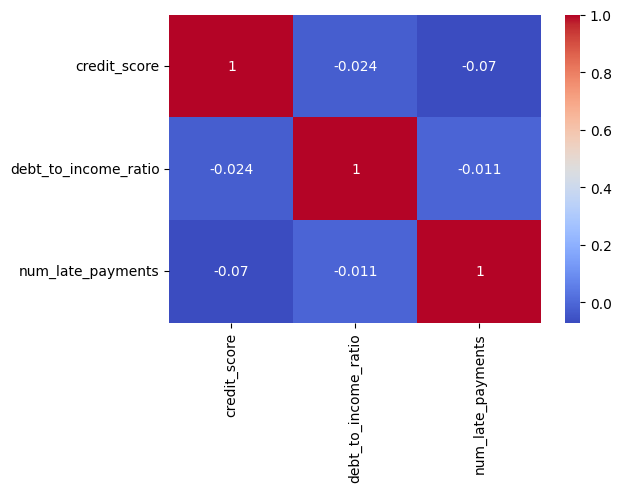

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
# Checking for Multicollinearity among continuous variables using correlation matrix
plt.figure(figsize=(6, 4))
sns.heatmap(x_train[continuous_vars].corr(), annot=True, cmap='coolwarm')
plt.show()

# <font face = 'Palatino Linotype' color = '#5885AF'> Modelling: KNN<font/>

In [15]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

pipeline = Pipeline(
    steps=[
        ("scaler", StandardScaler()),
        ("knn", KNeighborsClassifier())
    ]
)

param_grid = {
    "knn__n_neighbors": list(range(3, 21)),
    "knn__weights": ["uniform", "distance"],
    "knn__p": [1, 2]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=cv,
    scoring='accuracy',
    n_jobs=-1
)

grid_search.fit(x_train, y_train)

best_knn = grid_search.best_estimator_

# CV Score
print("Best Hyperparameters:", grid_search.best_params_)
print("Best Cross-Validation Accuracy:", grid_search.best_score_)

# Train Score
y_train_pred = best_knn.predict(x_train)
train_accuracy = accuracy_score(y_train, y_train_pred)
print("Train Accuracy:", train_accuracy)

# Test Score
y_pred = best_knn.predict(x_test)
test_accuracy = accuracy_score(y_test, y_pred)
print("Test Accuracy:", test_accuracy)

Best Hyperparameters: {'knn__n_neighbors': 15, 'knn__p': 2, 'knn__weights': 'uniform'}
Best Cross-Validation Accuracy: 0.9038729735731735
Train Accuracy: 0.9139966273187183
Test Accuracy: 0.8905723905723906


In [16]:
print("\nClassification Report:\n", classification_report(y_test, y_pred))

metrics = {
    "Accuracy": accuracy_score(y_test, y_pred),
    "Precision": precision_score(y_test, y_pred, average='macro'),
    "Recall": recall_score(y_test, y_pred, average='macro'),
    "F1-score": f1_score(y_test, y_pred, average='macro')
}

results_df = np.round(pd.DataFrame(metrics, index=['Score']),2)
print(results_df)


Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.86      0.88       290
           1       0.87      0.92      0.90       304

    accuracy                           0.89       594
   macro avg       0.89      0.89      0.89       594
weighted avg       0.89      0.89      0.89       594

       Accuracy  Precision  Recall  F1-score
Score      0.89       0.89    0.89      0.89


tp: 280 fn: 24 fp: 41 tn: 249


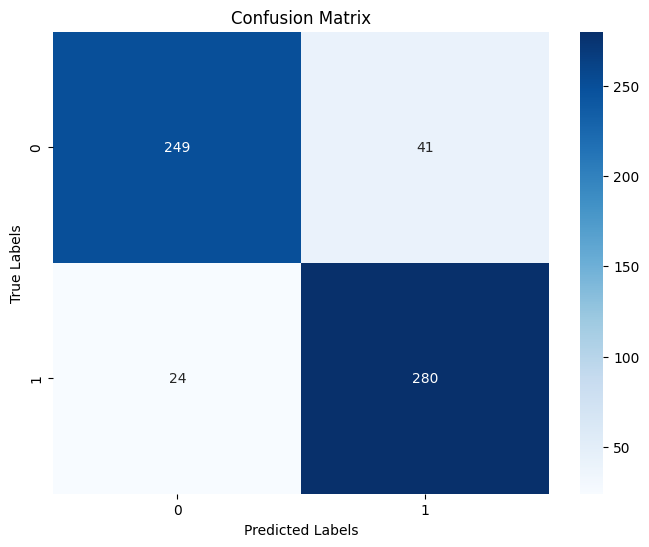

In [17]:
# Let us fit the KNN Model using the hyperparameters for our best model
from sklearn import tree
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Define class labels.
class_labels = np.unique(y_test)

# Create a confusion matrix.
cm = confusion_matrix(y_test, y_pred, labels=class_labels)

# Proper labelling of outcomes.
tn, fp, fn, tp= confusion_matrix(y_test, y_pred, labels=class_labels).ravel()
print("tp:", tp,"fn:", fn,"fp:",fp,"tn:", tn )

# Create a heatmap of the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

# <font face = 'Palatino Linotype' color = '#5885AF'> Modelling: Decision Trees<font/>

In [23]:
pipeline.get_params().keys()

dict_keys(['memory', 'steps', 'transform_input', 'verbose', 'scaler', 'tree', 'scaler__copy', 'scaler__with_mean', 'scaler__with_std', 'tree__ccp_alpha', 'tree__class_weight', 'tree__criterion', 'tree__max_depth', 'tree__max_features', 'tree__max_leaf_nodes', 'tree__min_impurity_decrease', 'tree__min_samples_leaf', 'tree__min_samples_split', 'tree__min_weight_fraction_leaf', 'tree__monotonic_cst', 'tree__random_state', 'tree__splitter'])

In [25]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score

# Define classifier with random state
pipeline = Pipeline(
    steps=[
        ("scaler", StandardScaler()),
        ("tree", DecisionTreeClassifier(random_state = 42))
    ]
)
# Hyperparameter grid
param_grid = {
    "tree__max_depth": [None, 5, 10, 15],  # Maximum depth of the tree
    "tree__min_samples_split": [2, 5, 10],  # Minimum number of samples required to split an internal node
    "tree__min_samples_leaf": [1, 2, 4], # Minimum number of samples required to be at a leaf node
    "tree__criterion": ["gini", "entropy"]  # Split criterion ('gini' or 'entropy')
}

# Stratified CV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Grid search
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=cv,
    scoring='accuracy',
    n_jobs=-1
)

grid_search.fit(x_train, y_train)

# Best model
best_tree = grid_search.best_estimator_

print("Best Hyperparameters:", grid_search.best_params_)
print("Best CV Accuracy Score:", grid_search.best_score_)

# Train evaluation
y_train_pred = best_tree.predict(x_train)
print("Train Accuracy:", accuracy_score(y_train, y_train_pred))

# Test evaluation
y_pred = best_tree.predict(x_test)
print("Test Accuracy:", accuracy_score(y_test, y_pred))

Best Hyperparameters: {'tree__criterion': 'gini', 'tree__max_depth': 5, 'tree__min_samples_leaf': 1, 'tree__min_samples_split': 2}
Best CV Accuracy Score: 0.8806893182322895
Train Accuracy: 0.904300168634064
Test Accuracy: 0.877104377104377


In [26]:
print("\nClassification Report:\n", classification_report(y_test, y_pred))

metrics = {
    "Accuracy": accuracy_score(y_test, y_pred),
    "Precision": precision_score(y_test, y_pred, average='macro'),
    "Recall": recall_score(y_test, y_pred, average='macro'),
    "F1-score": f1_score(y_test, y_pred, average='macro')
}

results_df = np.round(pd.DataFrame(metrics, index=['Score']),2)
print(results_df)


Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.83      0.87       290
           1       0.85      0.92      0.89       304

    accuracy                           0.88       594
   macro avg       0.88      0.88      0.88       594
weighted avg       0.88      0.88      0.88       594

       Accuracy  Precision  Recall  F1-score
Score      0.88       0.88    0.88      0.88


tp: 281 fn: 23 fp: 50 tn: 240


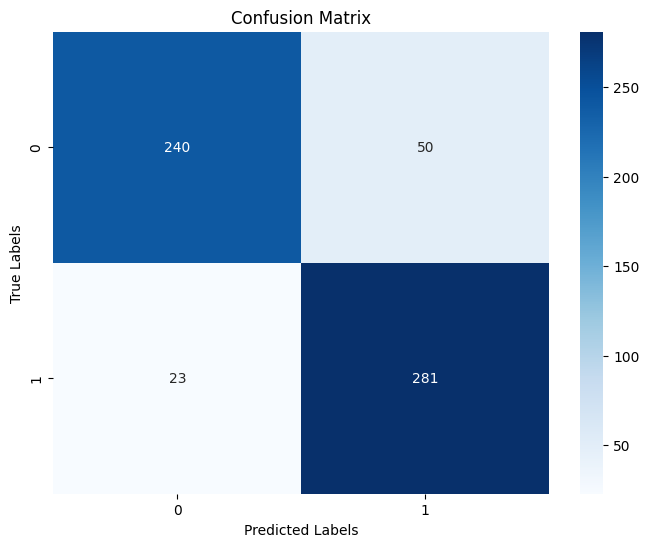

In [27]:
# Let us fit the Decision Tree Model using the hyperparameters for our best model
from sklearn import tree
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Make predictions using the best model on the test set.
y_pred = grid_search.predict(x_test)

# Define class labels.
class_labels = np.unique(y_test)

# Create a confusion matrix.
cm = confusion_matrix(y_test, y_pred, labels=class_labels)

# Proper labelling of outcomes.
tn, fp, fn, tp= confusion_matrix(y_test, y_pred, labels=class_labels).ravel()
print("tp:", tp,"fn:", fn,"fp:",fp,"tn:", tn )

# Create a heatmap of the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

# <font face = 'Palatino Linotype' color = '#5885AF'> Modelling: Logistic Regression<font/>

In [29]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report

pipeline = Pipeline(
    steps=[
        ("scaler", StandardScaler()),
        ("logreg", LogisticRegression())
    ]
)

In [32]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report

# Proper Stratified CV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=44)


pipeline = Pipeline(
    steps=[
        ("scaler", StandardScaler()),
        ("logreg", LogisticRegression(class_weight = 'balanced', 
                                      random_state=42,
                                     max_iter=500))
    ]
)

# Hyperparameter grid
param_grid = {
    'logreg__penalty': ['l1', 'l2'],
    'logreg__C': [0.01, 0.1, 1, 10, 100],
    'logreg__solver': ['liblinear'],  # 'liblinear' supports both L1 and L2
}

# Grid search using accuracy
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=cv,
    scoring='accuracy',   
    n_jobs=-1
)

# Fit grid search
grid_search.fit(x_train, y_train)

# Best model
best_logreg = grid_search.best_estimator_

print("Best Hyperparameters:", grid_search.best_params_)
print("Best CV Accuracy:", grid_search.best_score_)

# Train prediction
y_train_pred = best_logreg.predict(x_train)
print("\nTrain Accuracy:", accuracy_score(y_train, y_train_pred))

# Test prediction
y_test_pred = best_logreg.predict(x_test)
print("Test Accuracy:", accuracy_score(y_test, y_test_pred))

Best Hyperparameters: {'logreg__C': 0.1, 'logreg__penalty': 'l2', 'logreg__solver': 'liblinear'}
Best CV Accuracy: 0.9068238951809905

Train Accuracy: 0.9080944350758853
Test Accuracy: 0.8888888888888888


In [33]:
print("\nClassification Report:\n", classification_report(y_test, y_pred))

metrics = {
    "Accuracy": accuracy_score(y_test, y_pred),
    "Precision": precision_score(y_test, y_pred, average='macro'),
    "Recall": recall_score(y_test, y_pred, average='macro'),
    "F1-score": f1_score(y_test, y_pred, average='macro')
}

results_df = np.round(pd.DataFrame(metrics, index=['Score']),2)
print(results_df)


Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.83      0.87       290
           1       0.85      0.92      0.89       304

    accuracy                           0.88       594
   macro avg       0.88      0.88      0.88       594
weighted avg       0.88      0.88      0.88       594

       Accuracy  Precision  Recall  F1-score
Score      0.88       0.88    0.88      0.88


tp: 252 fn: 38 fp: 28 tn: 276


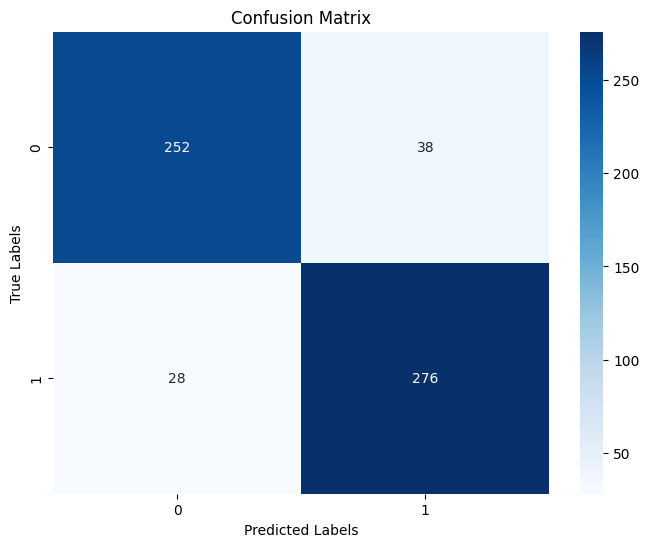

In [35]:
# Let us fit the Logistic Regression Model using the hyperparameters for our best model
from sklearn import tree
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Print the Logistic Regression Model performance on our test set.
y_pred = grid_search.predict(x_test)

# Define class labels.
class_labels = np.unique(y_test)

# Compute confusion matrix.
cm = confusion_matrix(y_test, y_pred, labels=class_labels)

# Proper labelling of outcomes.
tp, fn, fp, tn= confusion_matrix(y_test, y_pred, labels=class_labels).ravel()
print("tp:", tp,"fn:", fn,"fp:",fp,"tn:", tn )

# Create a heatmap of the confusion matrix.
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

# <font face = 'Palatino Linotype' color = '#5885AF'> Modelling: Random Forest<font/>

In [36]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


In [37]:
pipeline.get_params().keys()

dict_keys(['memory', 'steps', 'transform_input', 'verbose', 'scaler', 'rf', 'scaler__copy', 'scaler__with_mean', 'scaler__with_std', 'rf__bootstrap', 'rf__ccp_alpha', 'rf__class_weight', 'rf__criterion', 'rf__max_depth', 'rf__max_features', 'rf__max_leaf_nodes', 'rf__max_samples', 'rf__min_impurity_decrease', 'rf__min_samples_leaf', 'rf__min_samples_split', 'rf__min_weight_fraction_leaf', 'rf__monotonic_cst', 'rf__n_estimators', 'rf__n_jobs', 'rf__oob_score', 'rf__random_state', 'rf__verbose', 'rf__warm_start'])

In [38]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

pipeline = Pipeline(
    steps=[
        ("scaler", StandardScaler()),
        ("rf", RandomForestClassifier(random_state=42))
    ]
)

# Define the parameters of the Random Forest Classifier for Hyperparameter Tuning.
param_grid = {
    'rf__n_estimators': [10, 50, 100,200],
    'rf__max_depth': [None, 5, 10,20],
    'rf__min_samples_split': [2, 5, 10,15]
}

# Setup the grid search with accuracy scoring
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy', 
    n_jobs=-1
)

# Using GridSearchCV to determine the best model.
grid_search.fit(x_train, y_train)

# Get the best parameters and its Accuracy score
best_params = grid_search.best_params_
best_cv_accuracy = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best CV Accuracy:", best_cv_accuracy)

# Train the best model
best_rf = grid_search.best_estimator_

# Predictions
y_train_pred = best_rf.predict(x_train)
y_test_pred = best_rf.predict(x_test)

# Evaluate
print("\nTrain Accuracy:", accuracy_score(y_train, y_train_pred))
print("Test Accuracy:", accuracy_score(y_test, y_test_pred))

Best Parameters: {'rf__max_depth': 5, 'rf__min_samples_split': 10, 'rf__n_estimators': 100}
Best CV Accuracy: 0.8967017543859649

Train Accuracy: 0.9165261382799326
Test Accuracy: 0.8973063973063973


In [39]:
print("\nClassification Report:\n", classification_report(y_test, y_pred))

metrics = {
    "Accuracy": accuracy_score(y_test, y_pred),
    "Precision": precision_score(y_test, y_pred, average='macro'),
    "Recall": recall_score(y_test, y_pred, average='macro'),
    "F1-score": f1_score(y_test, y_pred, average='macro')
}

results_df = np.round(pd.DataFrame(metrics, index=['Score']),2)
print(results_df)


Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.87      0.88       290
           1       0.88      0.91      0.89       304

    accuracy                           0.89       594
   macro avg       0.89      0.89      0.89       594
weighted avg       0.89      0.89      0.89       594

       Accuracy  Precision  Recall  F1-score
Score      0.89       0.89    0.89      0.89


Test f1 Score = 0.9030206677265501
Test recall Score = 0.9342105263157895
Test precision Score = 0.8738461538461538
tp: 249 fn: 41 fp: 20 tn: 284


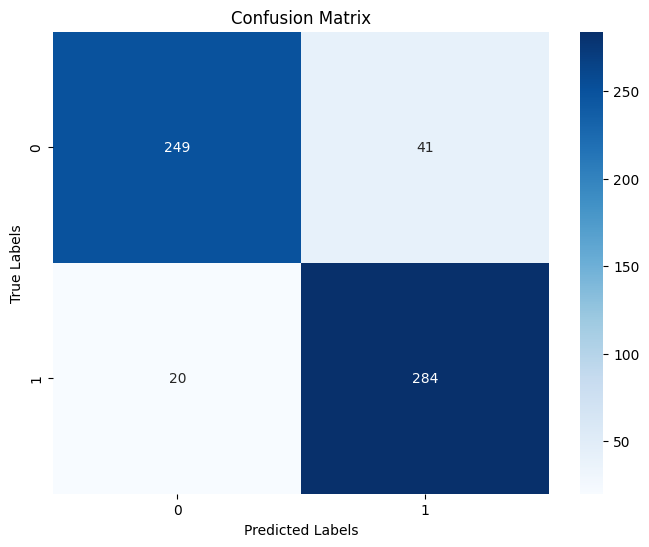

In [40]:
from sklearn import tree
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Print the RF Model performance on our test set.
y_pred = grid_search.predict(x_test)

# Calculate model performance such as F1, Recall, and Precision. 
from sklearn import metrics
print("Test f1 Score =",metrics.f1_score(y_test, y_pred, pos_label = 1))
print("Test recall Score =",metrics.recall_score(y_test, y_pred, pos_label = 1))
print("Test precision Score =",metrics.precision_score(y_test, y_pred, pos_label = 1))


# Define class labels.
class_labels = np.unique(y_test)

# Compute confusion matrix.
cm = confusion_matrix(y_test, y_pred, labels=class_labels)

# Proper labelling of outcomes.
tp, fn, fp, tn= confusion_matrix(y_test, y_pred, labels=class_labels).ravel()
print("tp:", tp,"fn:", fn,"fp:",fp,"tn:", tn )

# Create a heatmap of the confusion matrix.
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

# <font face = 'Palatino Linotype' color = '#5885AF'> Saving the Model for Future Deployment<font/>

In [41]:
# Save a copy of the Random Forest Model.
import pickle
pickle.dump(best_rf, open('RFPaymodelN.pkl', 'wb'))

# Decision

Given the results of the CV Accuracy across the different models, Random Forest Classifier have promising model performance compared to other trained models. Its CV accuracy is consistent with Train accuracy indicating no overfit. It also performs well on the unseen test data having an accuracy of near 0.9.